In [539]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import mlflow

In [540]:
mlflow.set_experiment("salary_prediction")

<Experiment: artifact_location='file:///c:/DijonMLOPS/mlruns/209491140600820065', creation_time=1713786539217, experiment_id='209491140600820065', last_update_time=1713786539217, lifecycle_stage='active', name='salary_prediction', tags={}>

In [541]:
# The initial dataset has been downloaded on the data folder.
# We open it with pandas

df = pd.read_csv('data/ds_salaries.csv')

In [542]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [543]:
df.sample(10)

work_year experience_level employment_type                  job_title  \
196        2023               MI              FT          Research Engineer   
1854       2022               SE              FT  Machine Learning Engineer   
3219       2022               MI              FT             Data Scientist   
1278       2023               MI              FT               Data Analyst   
2152       2022               SE              FT                ML Engineer   
847        2023               SE              FT  Machine Learning Engineer   
1446       2023               SE              FT             Data Scientist   
2670       2022               SE              FT              Data Engineer   
1496       2023               SE              FT               Data Analyst   
1256       2023               SE              FT              Data Engineer   

      salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
196   230000             USD         230000                 US             0   
1854  160000             USD         160000                 US           100   
3219   35000             GBP          43096                 GB             0   
1278   70000             GBP          85066                 GB             0   
2152  243000             USD         243000                 US           100   
847   153400             USD         153400                 US             0   
1446  237000             USD         237000                 US           100   
2670  300000             USD         300000                 US             0   
1496  141290             USD         141290                 US             0   
1256  163625             USD         163625                 US           100   

     company_location company_size  
196                US            M  
1854               US            M  
3219               GB            M  
1278               GB            M  
2152               US            M  
847                US            M  
1446               US            M  
2670               US            M  
1496               US            M  
1256               US            M

In [544]:
# list the different values of the column "salary_currency"
df['salary_currency'].value_counts()

salary_currency
USD    3224
EUR     236
GBP     161
INR      60
CAD      25
AUD       9
SGD       6
BRL       6
PLN       5
CHF       4
HUF       3
DKK       3
JPY       3
TRY       3
THB       2
ILS       1
HKD       1
CZK       1
MXN       1
CLP       1
Name: count, dtype: int64

In [545]:
# delete rows with salary_currency different from ['USD', 'EUR', 'GBP']
df = df[df['salary_currency'].isin(['USD', 'EUR', 'GBP'])]

In [546]:
usd_to_eur = 0.94  # 1 USD = 0.94 EUR
gbp_to_eur = 1.14  # 1 GBP = 1.14 EUR 
inr_to_eur = 0.011 # 1 INR = 0.011 EUR
cad_to_eur = 0.70  # 1 CAD = 0.70 EUR
aud_to_eur = 0.64  # 1 AUD = 0.64 EUR
sgd_to_eur = 0.71  # 1 SGD = 0.71 EUR [[10]]
brl_to_eur = 0.18  # 1 BRL = 0.18 EUR [[1]]
pln_to_eur = 0.22  # 1 PLN = 0.22 EUR [[2]] 
chf_to_eur = 1.01  # 1 CHF = 1.01 EUR
huf_to_eur = 0.0027 # 1 HUF = 0.0027 EUR [[2]]
dkk_to_eur = 0.13  # 1 DKK = 0.13 EUR [[2]]
jpy_to_eur = 0.0073 # 1 JPY = 0.0073 EUR [[2]]
try_to_eur = 0.051 # 1 TRY = 0.051 EUR [[2]]
thb_to_eur = 0.027 # 1 THB = 0.027 EUR 
ils_to_eur = 0.26  # 1 ILS = 0.26 EUR
hkd_to_eur = 0.12  # 1 HKD = 0.12 EUR
czk_to_eur = 0.041 # 1 CZK = 0.041 EUR [[2]]
mxn_to_eur = 0.052 # 1 MXN = 0.052 EUR
clp_to_eur = 0.0011 # 1 CLP = 0.0011 EUR


In [547]:
# create a new column "salary_eur" that contains the salary in EUR
df['salary_eur'] = df['salary']

# set type of df['salary_eur'] to float
df['salary_eur'] = df['salary_eur'].astype(float)

df.loc[df['salary_currency'] == 'USD', 'salary_eur'] = df['salary'] * usd_to_eur
df.loc[df['salary_currency'] == 'GBP', 'salary_eur'] = df['salary'] * gbp_to_eur
df.loc[df['salary_currency'] == 'INR', 'salary_eur'] = df['salary'] * inr_to_eur
df.loc[df['salary_currency'] == 'CAD', 'salary_eur'] = df['salary'] * cad_to_eur
df.loc[df['salary_currency'] == 'AUD', 'salary_eur'] = df['salary'] * aud_to_eur
df.loc[df['salary_currency'] == 'SGD', 'salary_eur'] = df['salary'] * sgd_to_eur
df.loc[df['salary_currency'] == 'BRL', 'salary_eur'] = df['salary'] * brl_to_eur
df.loc[df['salary_currency'] == 'PLN', 'salary_eur'] = df['salary'] * pln_to_eur
df.loc[df['salary_currency'] == 'CHF', 'salary_eur'] = df['salary'] * chf_to_eur
df.loc[df['salary_currency'] == 'HUF', 'salary_eur'] = df['salary'] * huf_to_eur
df.loc[df['salary_currency'] == 'DKK', 'salary_eur'] = df['salary'] * dkk_to_eur
df.loc[df['salary_currency'] == 'JPY', 'salary_eur'] = df['salary'] * jpy_to_eur
df.loc[df['salary_currency'] == 'TRY', 'salary_eur'] = df['salary'] * try_to_eur
df.loc[df['salary_currency'] == 'THB', 'salary_eur'] = df['salary'] * thb_to_eur
df.loc[df['salary_currency'] == 'ILS', 'salary_eur'] = df['salary'] * ils_to_eur
df.loc[df['salary_currency'] == 'HKD', 'salary_eur'] = df['salary'] * hkd_to_eur
df.loc[df['salary_currency'] == 'CZK', 'salary_eur'] = df['salary'] * czk_to_eur
df.loc[df['salary_currency'] == 'MXN', 'salary_eur'] = df['salary'] * mxn_to_eur
df.loc[df['salary_currency'] == 'CLP', 'salary_eur'] = df['salary'] * clp_to_eur

In [548]:
def get_salary_range(salary):
    return round(int(salary / 10000), 1)

df['salary_range'] = df['salary_eur'].apply(get_salary_range)

In [549]:
df.sample(10)

work_year experience_level employment_type                  job_title  \
1432       2023               MI              FT  Machine Learning Engineer   
2909       2022               EN              FT             Data Scientist   
3221       2022               MI              FT              Data Engineer   
3751       2021               MI              FT   Principal Data Scientist   
475        2023               SE              FT               Data Analyst   
1170       2023               SE              FT             Data Scientist   
557        2023               SE              FT               Data Analyst   
1701       2023               SE              FT               Data Analyst   
2746       2022               SE              FT                ML Engineer   
3647       2021               SE              FT             Data Scientist   

      salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
1432  150000             USD         150000                 US           100   
2909   30000             EUR          31520                 ES            50   
3221   45000             EUR          47280                 GR           100   
3751  151000             USD         151000                 US           100   
475    80000             USD          80000                 US           100   
1170  156400             USD         156400                 US             0   
557   153600             USD         153600                 US             0   
1701  137500             USD         137500                 US             0   
2746  131300             USD         131300                 US           100   
3647  135000             USD         135000                 US             0   

     company_location company_size  salary_eur  salary_range  
1432               US            M    141000.0            14  
2909               ES            M     30000.0             3  
3221               GR            M     45000.0             4  
3751               US            L    141940.0            14  
475                US            M     75200.0             7  
1170               US            M    147016.0            14  
557                US            M    144384.0            14  
1701               US            M    129250.0            12  
2746               US            L    123422.0            12  
3647               US            L    126900.0            12

In [550]:
df.sample(10)

work_year experience_level employment_type                  job_title  \
1593       2023               SE              FT              Data Engineer   
1608       2023               MI              FT               Data Analyst   
1106       2023               SE              FT             Data Scientist   
1949       2022               SE              FT              Data Engineer   
252        2023               SE              FT               Data Analyst   
529        2023               SE              FT  Machine Learning Engineer   
716        2023               SE              FT             Data Scientist   
3139       2022               EN              FT               Data Analyst   
1355       2023               SE              FT  Machine Learning Engineer   
906        2023               SE              FT               Data Manager   

      salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
1593  300000             USD         300000                 US             0   
1608  105500             USD         105500                 US             0   
1106  245000             USD         245000                 US             0   
1949   95000             USD          95000                 US             0   
252   135000             USD         135000                 US             0   
529   216000             USD         216000                 US           100   
716   297300             USD         297300                 US           100   
3139   15000             USD          15000                 ID             0   
1355  142200             USD         142200                 US             0   
906   155000             USD         155000                 US             0   

     company_location company_size  salary_eur  salary_range  
1593               US            M    282000.0            28  
1608               US            M     99170.0             9  
1106               US            M    230300.0            23  
1949               US            M     89300.0             8  
252                US            M    126900.0            12  
529                US            M    203040.0            20  
716                US            M    279462.0            27  
3139               ID            L     14100.0             1  
1355               US            M    133668.0            13  
906                US            M    145700.0            14

In [551]:
# drop columns "salary" and "salary_currency" and "salary_in_usd"
df = df.drop(columns=['salary', 'salary_currency', 'salary_in_usd', 'salary_eur'])

In [552]:
df.sample(10)

work_year experience_level employment_type                  job_title  \
3283       2022               SE              FT              Data Engineer   
1436       2023               SE              FT             Data Scientist   
3674       2020               MI              FT               Data Analyst   
2827       2022               EX              FT       Data Science Manager   
2012       2022               MI              FT               Data Analyst   
1320       2023               MI              FT  Machine Learning Engineer   
734        2023               SE              FT               Data Analyst   
725        2023               SE              FT         Analytics Engineer   
2398       2022               SE              FT             Data Scientist   
971        2022               EN              PT               Data Analyst   

     employee_residence  remote_ratio company_location company_size  \
3283                 GB             0               GB            M   
1436                 US           100               US            M   
3674                 US           100               US            L   
2827                 US             0               US            M   
2012                 GB             0               GB            M   
1320                 GB             0               GB            M   
734                  US             0               US            M   
725                  US           100               US            M   
2398                 US             0               US            M   
971                  US           100               US            S   

      salary_range  
3283             5  
1436            14  
3674             7  
2827            17  
2012             5  
1320            11  
734              9  
725             17  
2398            17  
971              3

<Axes: >

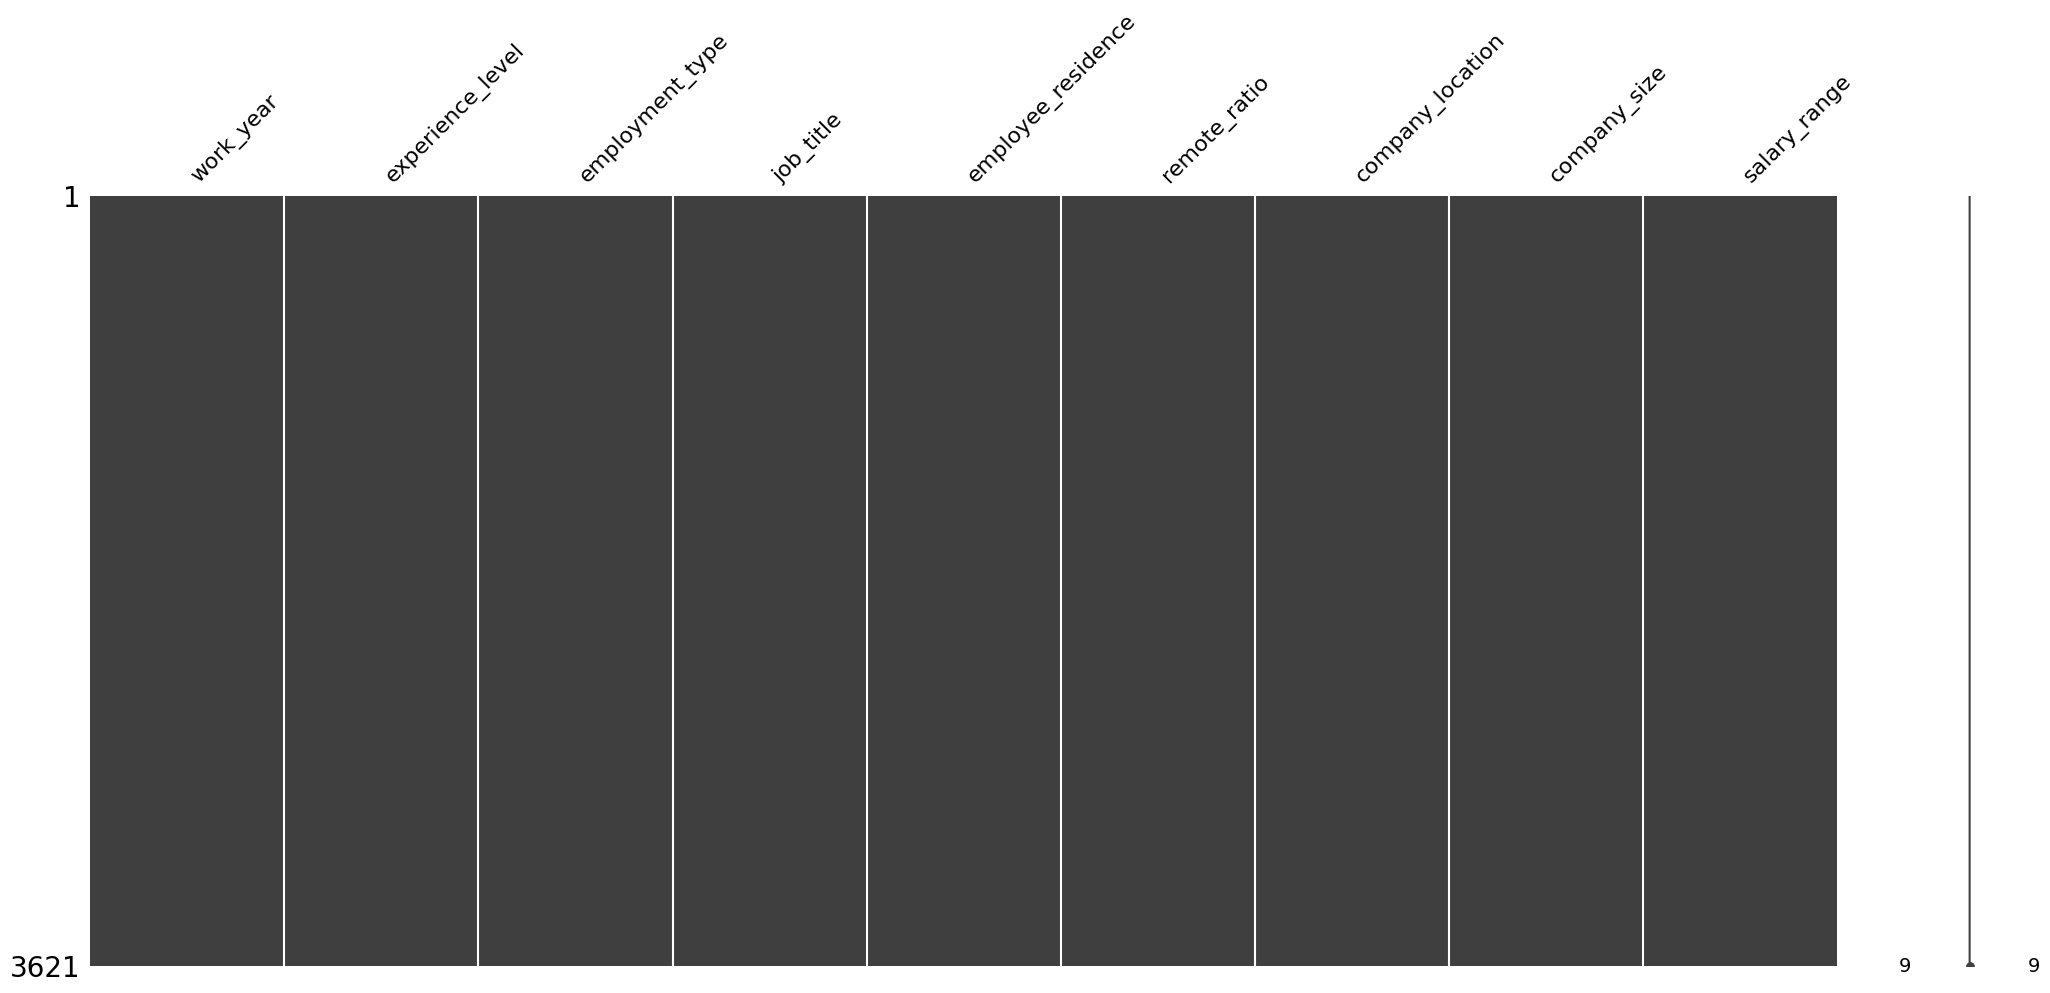

In [553]:
msno.matrix(df)

<Axes: >

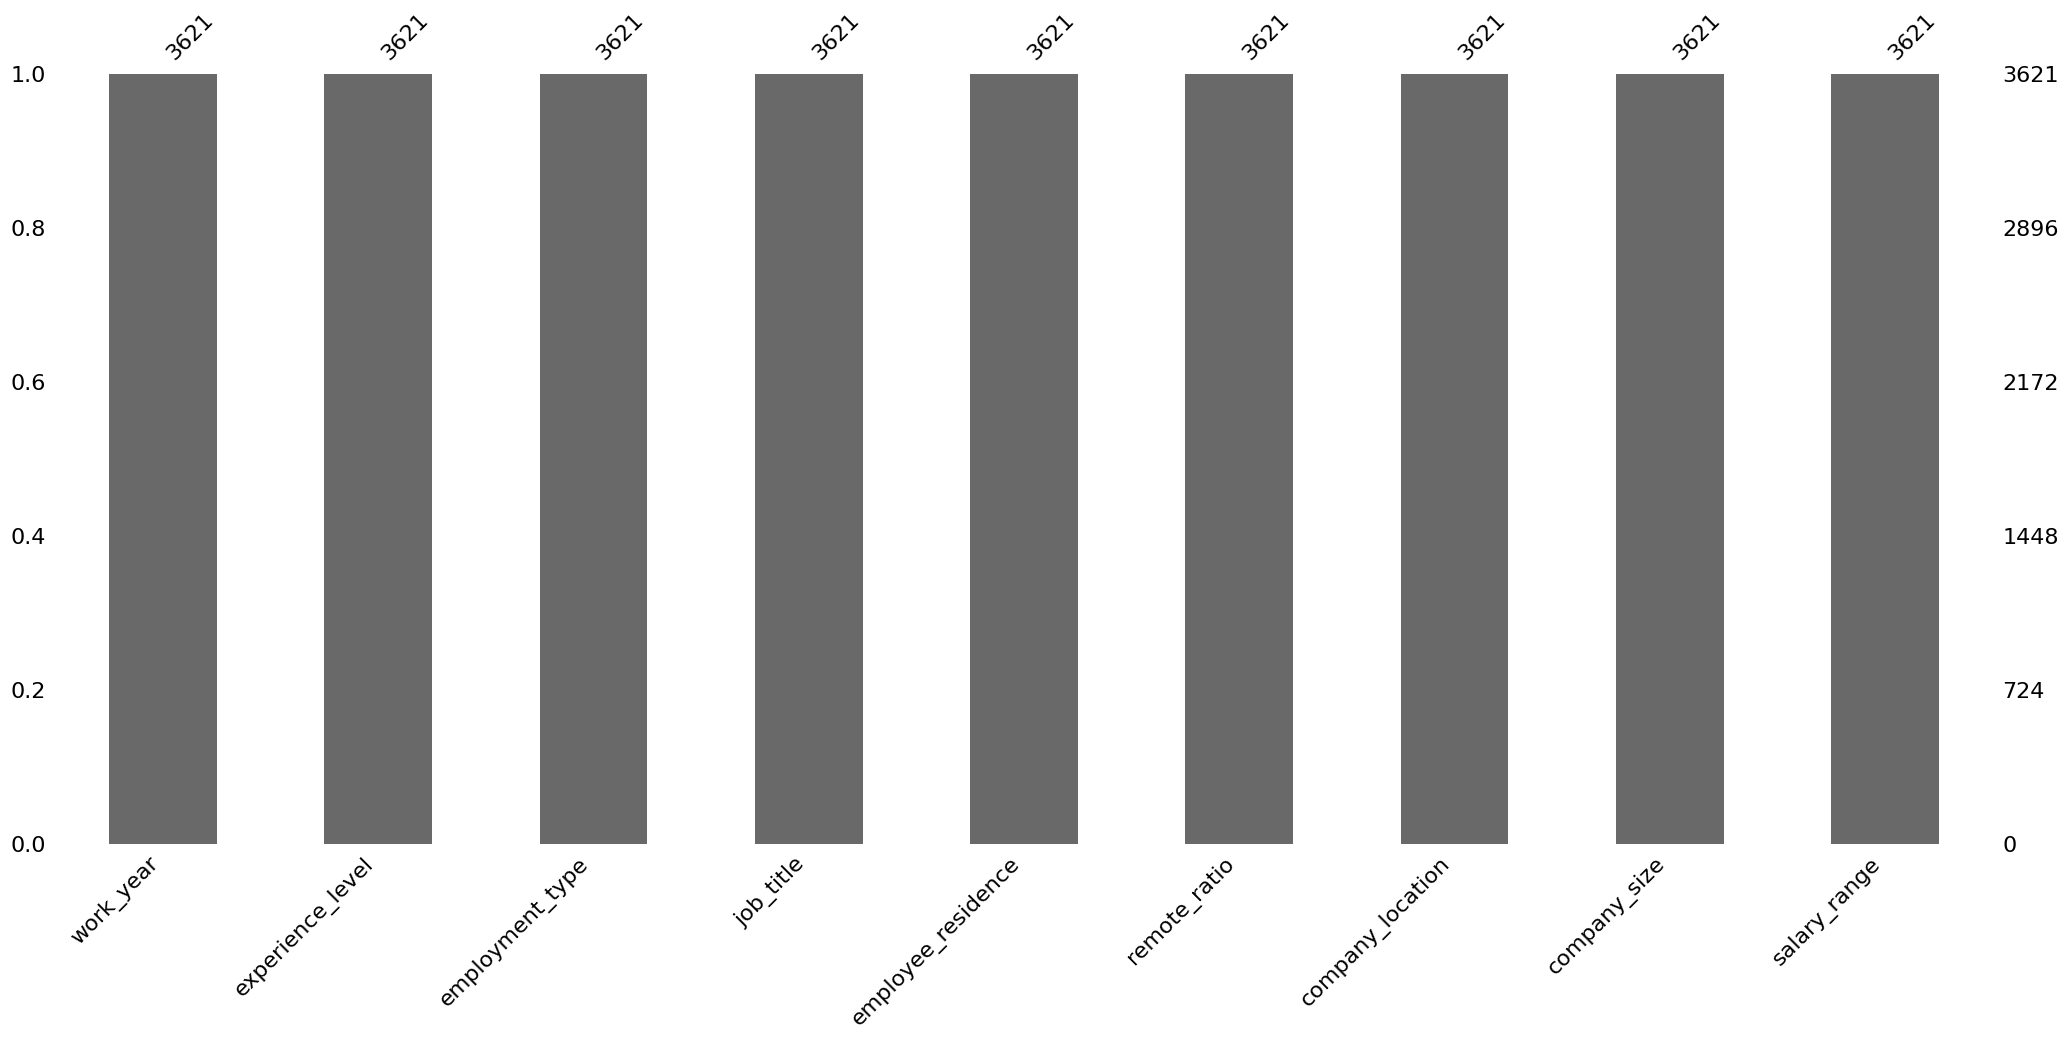

In [554]:
msno.bar(df)

In [555]:
# Split the df dataframe into two dataframes : df_train and df_added (1000 lines in df_added, the rest in df_train. Chose lines randomly)
df_added = df.sample(1000)
df_train = df.drop(df_added.index)

df_added.to_csv('data/ds_salaries_added.csv', index=False)
df_train.to_csv('data/ds_salaries_train.csv', index=False)

In [556]:
# We now focus on the train dataset
df = pd.read_csv('data/ds_salaries_train.csv')

In [557]:
# Remove variables df_added and df_train
del df_added, df_train

In [558]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2621 entries, 0 to 2620
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2621 non-null   int64 
 1   experience_level    2621 non-null   object
 2   employment_type     2621 non-null   object
 3   job_title           2621 non-null   object
 4   employee_residence  2621 non-null   object
 5   remote_ratio        2621 non-null   int64 
 6   company_location    2621 non-null   object
 7   company_size        2621 non-null   object
 8   salary_range        2621 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 184.4+ KB


In [559]:
df.sample(10)

work_year experience_level employment_type                  job_title  \
2156       2022               MI              FT            BI Data Analyst   
1090       2023               SE              FT                 BI Analyst   
2003       2022               SE              FT             Data Architect   
1450       2022               EN              FT  Machine Learning Engineer   
1517       2022               EN              FT    Data Analytics Engineer   
1444       2022               MI              FT             MLOps Engineer   
1271       2023               SE              FT             Data Scientist   
2440       2022               SE              FT  Machine Learning Engineer   
1491       2022               MI              FT             Data Scientist   
954        2023               MI              FT             Data Scientist   

     employee_residence  remote_ratio company_location company_size  \
2156                 DE           100               DE            S   
1090                 US             0               US            M   
2003                 US           100               US            M   
1450                 AR           100               AR            L   
1517                 AR           100               AR            S   
1444                 US           100               US            M   
1271                 CA             0               CA            M   
2440                 NL           100               NL            L   
1491                 US             0               US            M   
954                  US           100               US            M   

      salary_range  
2156             4  
1090            10  
2003            17  
1450             1  
1517             1  
1444            12  
1271            10  
2440             5  
1491            16  
954             10

In [560]:
# Séparer les features (X) et la target (y)
X = df.drop('salary_range', axis=1)
y = df['salary_range']

In [561]:
# Définir les colonnes catégorielles
cat_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

# Créer l'objet OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')

# Créer le ColumnTransformer
ct = ColumnTransformer(transformers=[('encoder', ohe, cat_cols)], remainder='passthrough')

# Appliquer la transformation à X
X_encoded = ct.fit_transform(X)

In [562]:
# transform numeric columns to normalised values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_encoded = scaler.fit_transform(X_encoded)

In [563]:
#y_normalized = y / y.max()

In [564]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [565]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [566]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [567]:
# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.24
MAE: 3.32
R^2: 0.36


### Avec une version "naive" de xgboost, le score n'est pas bon. Il va falloir optimiser les hyperparamètres.

## GridsearchCV avec XGBoost

In [568]:
param_grid_xgb = {
    'max_depth': [2,3,4,5,6,7],
    'learning_rate': [0.05,0.06,0.07,0.08,0.09],
    'n_estimators': [200,300,400,500],
}


In [569]:
grid_search_xgb = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), 
                           param_grid=param_grid_xgb,
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # utiliser tous les CPU
                           verbose=2)  # afficher les logs


In [570]:
grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [200, 300, 400, 500]},
             verbose=2)

In [571]:
print(f"Meilleurs hyperparamètres : {grid_search_xgb.best_params_}")
print(f"Meilleur score de validation croisée : {grid_search_xgb.best_score_:.4f}")

Meilleurs hyperparamètres : {'learning_rate': 0.09, 'max_depth': 2, 'n_estimators': 500}
Meilleur score de validation croisée : 0.3555


In [572]:
y_pred = grid_search_xgb.predict(X_test)
print(f"RMSE sur l'ensemble de test : {root_mean_squared_error(y_test, y_pred):.2f}")

RMSE sur l'ensemble de test : 4.31


In [573]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.31
MAE: 3.38
R^2: 0.34


In [574]:
# select best model
best_model_xgb = grid_search_xgb.best_estimator_

In [575]:
with mlflow.start_run():
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)
    mlflow.xgboost.log_model(best_model_xgb, "model")

c:\Users\jeanc\.conda\envs\DijonMLOPS\lib\site-packages\xgboost\core.py:160: UserWarning: [15:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
c:\Users\jeanc\.conda\envs\DijonMLOPS\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\jeanc\.conda\envs\DijonMLOPS\lib\site-packages\_di

## GridSearchCV Random Forest

In [576]:
# show how many features exist on X_train
print(X_train.shape)

(2096, 222)


In [577]:
param_grid_rf = { 
    'n_estimators': [90,100,110],
    'max_features': [35,40,45],
    'max_depth' : [13,14,15],
    'criterion' :['squared_error']
}

In [578]:
rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                           cv=5, n_jobs=-1, verbose=2)

In [579]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [13, 14, 15],
                         'max_features': [35, 40, 45],
                         'n_estimators': [90, 100, 110]},
             verbose=2)

In [580]:
print(f"Best parameters: {grid_search_rf.best_params_}")  
print(f"Best cross-validation score: {grid_search_rf.best_score_:.4f}")

Best parameters: {'criterion': 'squared_error', 'max_depth': 13, 'max_features': 35, 'n_estimators': 110}
Best cross-validation score: 0.3436


In [581]:
y_pred = grid_search_rf.predict(X_test)
print(f"RMSE on test set: {root_mean_squared_error(y_test, y_pred):.2f}")

RMSE on test set: 4.24


In [582]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.24
MAE: 3.34
R^2: 0.36


In [583]:
# select the best model
best_model_rf = grid_search_rf.best_estimator_

In [584]:
with mlflow.start_run():
    mlflow.log_params(grid_search_rf.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(best_model_rf, "modelrf")

c:\Users\jeanc\.conda\envs\DijonMLOPS\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\jeanc\.conda\envs\DijonMLOPS\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## SVR

In [585]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.010,0.011,0.012],
    'epsilon': [2.49,2.5,2.51]
}

svr = SVR()
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search_svr.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.01, 0.011, 0.012],
                         'epsilon': [2.49, 2.5, 2.51],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [586]:
print(f"Best parameters: {grid_search_svr.best_params_}")  
print(f"Best cross-validation score: {grid_search_svr.best_score_:.4f}")

Best parameters: {'C': 0.012, 'epsilon': 2.49, 'kernel': 'linear'}
Best cross-validation score: 0.3463


In [587]:
y_pred = grid_search_svr.predict(X_test)
print(f"RMSE on test set: {root_mean_squared_error(y_test, y_pred):.2f}")

RMSE on test set: 4.27


In [588]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.27
MAE: 3.39
R^2: 0.35


In [589]:
# select the best model
best_model_svr = grid_search_svr.best_estimator_

In [590]:
with mlflow.start_run():
    mlflow.log_params(grid_search_svr.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(best_model_svr, "modelsvr")

c:\Users\jeanc\.conda\envs\DijonMLOPS\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\jeanc\.conda\envs\DijonMLOPS\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
